<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Tocando un poco de música<a id="top"></a>

<i><small>Autor: Alberto Díaz Álvarez<br>Última actualización: 2023-03-14</small></i></div>
                                                  

***

## Introducción

En este notebook vamos a crear un modelo que aprenderá a tocar "música". Lo del entrecomillado es debido a que, para tocar bien música, se necesitan modelos muy complejos y con técnicas que se escapan un poco de un tutorial como este.

Sin embargo, en este ejercicio tocaremos las bases de la generación en base a notas y acordes y, junto con los modelos que veremos más adelante en este tema más conceptos como redes bidireccionales y embeddings de la parte de Procesamiento de Lenguaje Natural (NLP) podremos generar música con un poco más de sentido.

## Objetivos

Crearemos un modelo de predicción de notas en base a una secuencia de notas previas. Al finalizar habremos aprendido a:

- Leer y escribir ficheros midi
- Generar secuencias siguiendo una tipología de red recurrente de tipo _one-to-many_
- Salvar modelos entrenados a disco para entrenar en diferentes momentos

## Imports y configuración

A continuación importaremos las librerías que se usarán a lo largo del notebook. Entre las que ya hemos visto durante el curso, importamos además:

- `music21` librería [Music21](https://web.mit.edu/music21/) que permite la manipulación de ficheros midi (de audio en general) de una forma relativamente sencilla

In [2]:
import glob

import music21
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Asímismo, configuramos algunos parámetros para adecuar la presentación gráfica.

In [3]:
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

***

## Carga y preparación de datos

Comenzaremos cargando todas las notas de los ficheros `.mid` localizados bajo el _path_ relativo `Datasets/Music`. Dichas notas las vamos a almacenar en una lista que llamaremos `notes`. Algunos detalles de implementación:

* Para parsear un fichero midi usaremos la función `parse(file)` del módulo `converter` de la librería `music21`
* Las notas que queremos obtener se encuentran en el atributo `.flat.notes` del midi parseado. Sin embargo hay que tener en cuenta que contiene dos tipos de datos:
  - Notas normales, que son de tipo `note.Note`. Si la nota es `note`, almacenaremos directamente en la lista notes la representación como cadena de `note.pitch`.
  - Acordes, que son de tipo `chord.Chord`. Estos son una lista de notas, y lo que almacenaremos será la lista de sus notas (si el acorde es `chord`, la lista será `chord.normalOrder`) como cadena te texto donde cada nota estará separada po un punto (`'.'`)

Esto no es por capricho; es una forma de representar las notas que nos hará fácil más tarde convertir las notas generadas en una nueva pista de audio.

In [4]:
notes = []  # Almacenará todas las notas y acordes de los ficheros

for file in glob.glob('Datasets/warcraft2/*.mid'):
    print(f'Parsing {file}')

    midi = music21.converter.parse(file)
    
    for note_or_chord in midi.flat.notes:
        if isinstance(note_or_chord, music21.note.Note):
            notes.append(str(note_or_chord.pitch))
        elif isinstance(note_or_chord, music21.chord.Chord):
            notes.append('.'.join(str(n) for n in note_or_chord.normalOrder))
notes[:10]

Parsing Datasets/warcraft2\Human1gm.mid
Parsing Datasets/warcraft2\Human2gm.mid
Parsing Datasets/warcraft2\Human3gm.mid
Parsing Datasets/warcraft2\Human4gm.mid
Parsing Datasets/warcraft2\humanv.mid
Parsing Datasets/warcraft2\Humdthgm.mid
Parsing Datasets/warcraft2\Hwrrmgm.mid
Parsing Datasets/warcraft2\Introgm.mid
Parsing Datasets/warcraft2\Orc1gm.mid
Parsing Datasets/warcraft2\Orc2gm.mid
Parsing Datasets/warcraft2\Orc3gm.mid
Parsing Datasets/warcraft2\Orc4gm.mid
Parsing Datasets/warcraft2\Orcdthgm.mid
Parsing Datasets/warcraft2\Orcvgm.mid
Parsing Datasets/warcraft2\owrrmgm.mid


['0', 'C4', 'C3', '6.7.0', '0.6', 'C4', '6.7', 'C3', '7.0', 'B2']

Nuestro siguiente paso será el de crear dos diccionarios: `note_to_int` y `int_to_note`. ¿Cuál será su comentido? Pues bien, tenemos la lista de todas las notas de todas las pistas de sonido. Como las redes trabajan con números, no con símbolos, lo que haremos será asignarle un valor único a cada nota diferente. Con estos dos diccionarios sabremos traducir de nota a su número y de un número a su nota para poder traducir hacia dentro y fuera de la red.

Por tanto, crearemos estos dos diccionarios con las diferentes notas ordenadas ascendentemente, desde el 0 hasta el número de notas menos uno.

In [5]:
note_to_int = {note: i for i, note in enumerate(sorted(set(notes)))}
int_to_note = {i: note for i, note in enumerate(sorted(set(notes)))}

Seguimos con la preparación de los conjuntos de datos. En `notes` tenemos la lista ordenada de notas. Es de esperar que las notas estén determinadas por la secuencia anterior. Por motivos de facilitar la implementación y la teoría, no hemos creado un nuevo token para indicar que una canción ha terminado, por lo que habrá ciertos cortes que no se correspondan con un ritmo real. Si te animas a modificarlo para que soporte esto, ¡adelante!

Lo que crearemos ahora será el conjunto de entrenamiento, las variables `X_train` e `Y_train`. `X_train` se compondrá de las secuencias de entrada, que serán de longitud 50 (la variable SEQUENCE_LEN, ya está creada), mientras que `Y_train` tendrá la correspondiente nota que sigue a esa secuencia. Construiremos este conjunto a partir de la lista `notes`.

In [6]:
SEQUENCE_LEN = 20

x_train = []
y_train = []

for i in range(SEQUENCE_LEN, len(notes)):
    input_notes = notes[i - SEQUENCE_LEN: i]
    output_note = notes[i]
    x_train.append([note_to_int[note] for note in input_notes])
    y_train.append(note_to_int[output_note])

for i in range(10):
    print(f'... {x_train[i][-10:]} -> {y_train[i]}')

... [0, 112, 11, 166, 105, 153, 0, 105, 112, 166] -> 11
... [112, 11, 166, 105, 153, 0, 105, 112, 166, 11] -> 153
... [11, 166, 105, 153, 0, 105, 112, 166, 11, 153] -> 0
... [166, 105, 153, 0, 105, 112, 166, 11, 153, 0] -> 167
... [105, 153, 0, 105, 112, 166, 11, 153, 0, 167] -> 166
... [153, 0, 105, 112, 166, 11, 153, 0, 167, 166] -> 106
... [0, 105, 112, 166, 11, 153, 0, 167, 166, 106] -> 11
... [105, 112, 166, 11, 153, 0, 167, 166, 106, 11] -> 105
... [112, 166, 11, 153, 0, 167, 166, 106, 11, 105] -> 209
... [166, 11, 153, 0, 167, 166, 106, 11, 105, 209] -> 112


Como vamos a alimentar a una red recurrente, las dimensiones de entrada deberían ser $M \times T \times C$, siendo:

* $M$: El número de ejemplos, es decir, el número total de secuencias
* $T$: El tamaño de la secuencia, que lo hemos definido en la constante anterior
* $C$: El número de parámetros que tiene cada elemento de la secuencia, que en nuestro caso es $1$ (cada nota es un único entero)

El problema es que las dimensiones de nuestro conjunto de entrenamiento no son esas, así que habrá que hacer un reshape

In [7]:
x_train = np.reshape(x_train, (len(x_train), SEQUENCE_LEN, 1)) # (M, T, C)

print(f'x_train shape: {x_train.shape}')

x_train shape: (23629, 20, 1)


Ahora normalizaremos los datos de entrada para que caigan dentro del intervalo $[0, 1]$, y convertiremos los datos de salida en formato _one-hot_

In [8]:
x_train = x_train / len(note_to_int)
y_train = tf.keras.utils.to_categorical(y_train)

print(f'An x_train value: {x_train[0][0]}, Y_train shape: {y_train.shape}')

An x_train value: [0.], Y_train shape: (23629, 214)


Y ya están los conjuntos creados y listos para entrenar. Ahora pasamos a trabajar con el modelo.

## Implementando y entrenando nuestro modelo

Vamos a añadir un elemento nuevo que no habíamos visto hasta ahora pero que es de gran utilidad cuando trabajamos con modelos grandes: un _callback_ para ir guardando checkpoints con los estados del modelo. Los argumentos del inicializador de la clase son bastante descriptivos.

In [9]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'tmp/model-{loss:.4f}.h5',
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

Ahora crearemos un modelo para que aprenda a predecir la siguiente nota dada una secuencia de notas. La estructura que segurá será la siguiente:

`Input`->`SimpleRNN-512`->`Dropout`->`SimpleRNN-256`->`Dropout`->`SimpleRnn-128`->`Dropout`->`SimpleRnn-64`->`Dropout`->`SimpleRnn-32`->`Dropout`->`Output`

El modelo lo compilaremos con el loss correspondiente a un problema de clasificación y como optimizador usaremos el algoritmo Adam.

In [10]:
LOAD_PREVIOUS = True

checkpoints = sorted(glob.glob('tmp/*.h5'))
if LOAD_PREVIOUS and checkpoints:
    print(f'Loading previous model: {checkpoints[0]}')
    model = tf.keras.models.load_model(checkpoints[0])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(512, return_sequences=True, input_shape=(*x_train.shape[1:],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(256, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
    ])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 20, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 256)           787456    
                                                                 
 dropout_1 (Dropout)         (None, 20, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 20, 128)           197120    
                                                                 
 dropout_2 (Dropout)         (None, 20, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 20, 64)            4

Ahora entrenaremos el modelo con nuestro conjunto de datos durante 10 epochs; no son muchos, pero la carga computacional derivada del entrenamiento de este tipo de modelos es bastante pesada. ¡Acuérdate de añadir el _callback_ para ir salvando el modelo!

In [11]:
history = model.fit(x_train, y_train, epochs=10, callbacks=[checkpoint])

Epoch 1/10
739/739 [==============================] - 243s 320ms/step - loss: 4.7348 - categorical_accuracy: 0.0335
Epoch 2/10
739/739 [==============================] - 253s 342ms/step - loss: 4.6799 - categorical_accuracy: 0.0337
Epoch 3/10
739/739 [==============================] - 270s 366ms/step - loss: 4.6719 - categorical_accuracy: 0.0342
Epoch 4/10
739/739 [==============================] - 277s 375ms/step - loss: 4.6709 - categorical_accuracy: 0.0358
Epoch 5/10
739/739 [==============================] - 274s 370ms/step - loss: 4.6686 - categorical_accuracy: 0.0347
Epoch 6/10
739/739 [==============================] - 316s 428ms/step - loss: 4.6667 - categorical_accuracy: 0.0357
Epoch 7/10
739/739 [==============================] - 350s 474ms/step - loss: 4.6656 - categorical_accuracy: 0.0341
Epoch 8/10
739/739 [==============================] - 307s 415ms/step - loss: 4.6641 - categorical_accuracy: 0.0350
Epoch 9/10
739/739 [==============================] - 267s 361ms/step - 

Antes de ver la evolución del error, podríamos modificar la creación del modelo para que cargase el mejor checkpoint en caso de que existiese y de que quisiésemos (mediante una variable, por ejemplo `LOAD_PREVIOUS`).

Ahora sí, veamos cómo han evolucionado el error y la precisión.

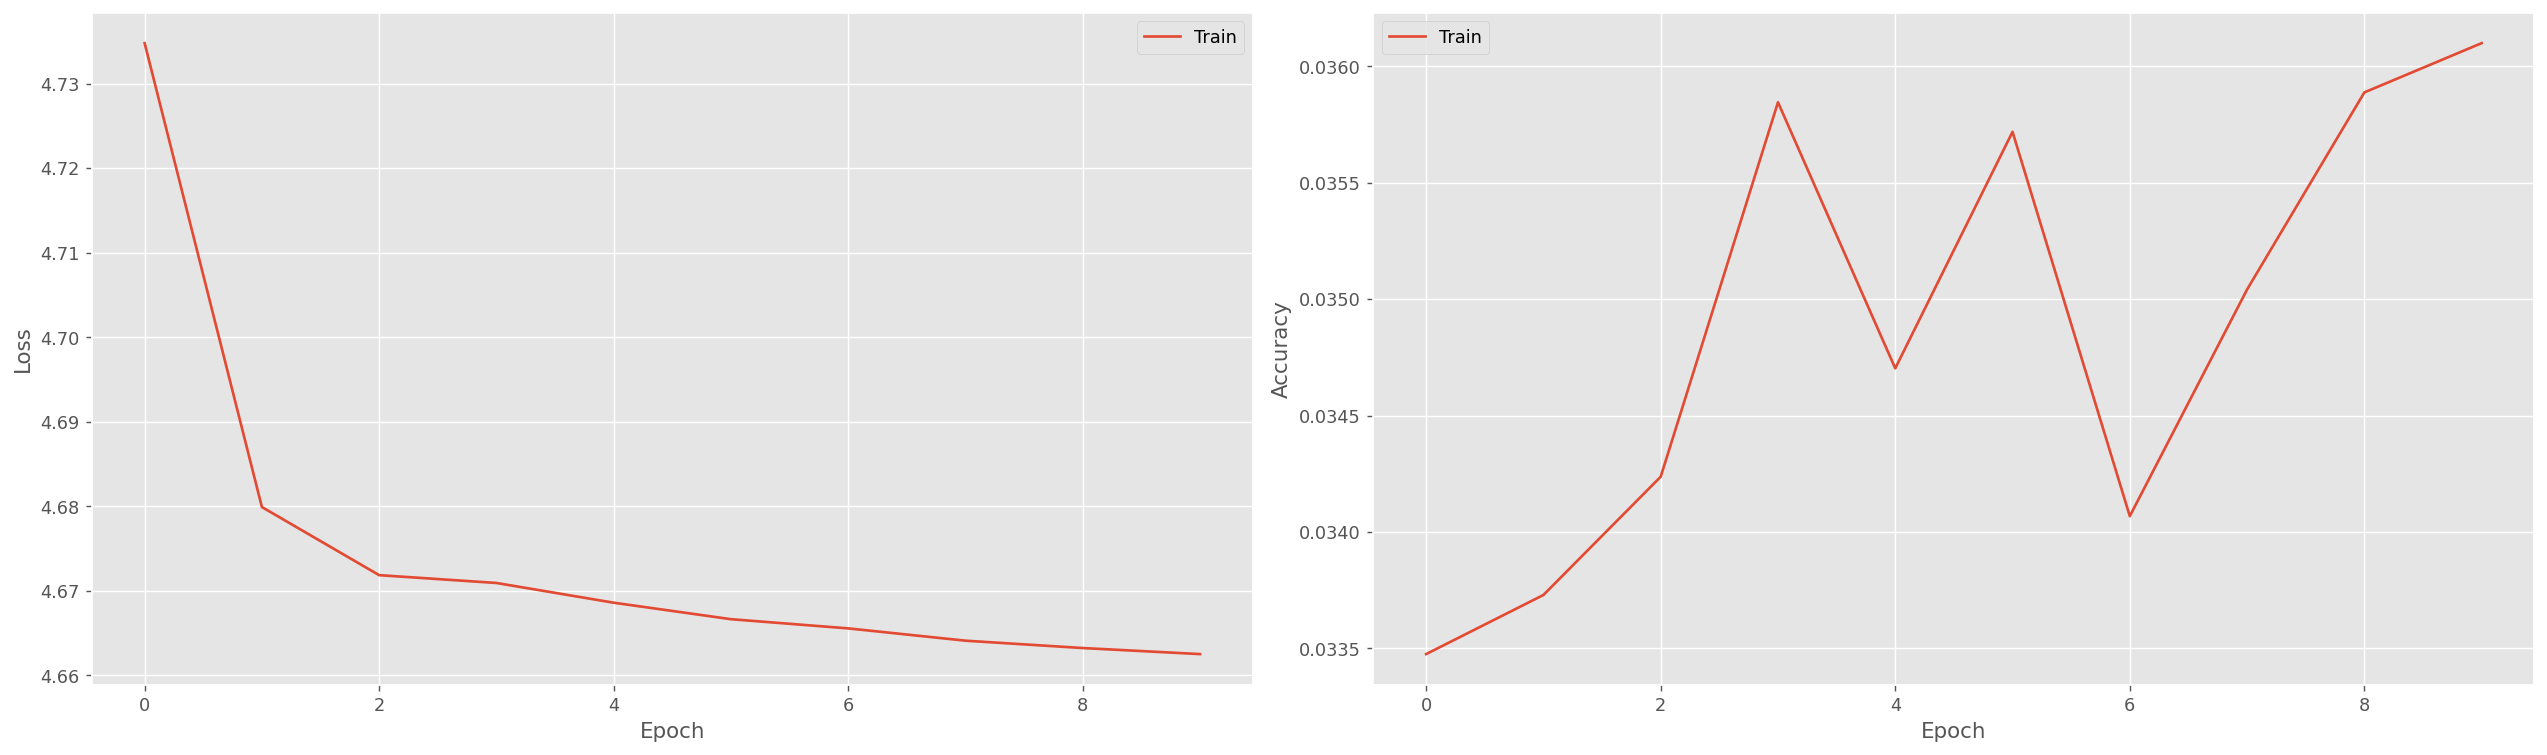

In [12]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Train')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Generemos un poco de música

Ya tenemos un modelo entrenado para que nos genere música. Procederemos ahora a generar una canción. Para mantenerlo sencillo, generaremos una canción de N notas (por ejemplo 100, y veremos cómo se comporta. Para ello:

1. Crearemos una secuencia aleatoria de arranque del tamaño de secuencia esperado. Esa será nuestra primera entrada
2. Le pasaremos dicha secuencia al modelo y recogeremos la siguiente nota que prediga.
3. Eliminaremos la primera nota de la secuencia y añadiremos la nueva nota al final; esta será la siguiente secuencia
4. Seguiremos así hasta que hayamos terminado de generar notas
5. El resultado será una lista con la secuencia y todas las notas generadas

La lista con las notas generadas se llamará `new_song`.

In [13]:
start   = np.random.randint(len(x_train) - 1)
pattern = x_train[start]

new_song = []
for _ in range(100):
    X = np.reshape(pattern, (1, SEQUENCE_LEN, 1))

    next_note_softmax = model.predict(X)
    next_note = np.argmax(next_note_softmax)

    new_song.append(int_to_note[next_note])

    pattern[:-1] = pattern[1:]
    pattern[-1] = next_note / len(note_to_int)
    
print(f'New song: {new_song}')

1/1 [==============================] - 0s 21ms/step
New song: ['F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2']


El siguiente fragmento de código transforma la lista de notas en un midi, separando cada nota medio segundo.

In [14]:
# Now let's create the midi given the song
offset = 0
output_notes = []

# Create notes and chords according with the specified song
for pattern in new_song:
    if ('.' in pattern) or pattern.isdigit():
        # Pattern is a chord, so let's split into notes and create it
        notes = []
        for current_note in pattern.split('.'):
            new_note = music21.note.Note(int(current_note))
            new_note.storedInstrument = music21.instrument.Violin()
            notes.append(new_note)
        new_chord = music21.chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    else:
        # Pattern is a note, so let's create it and that's all
        new_note = music21.note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = music21.instrument.Violin()
        output_notes.append(new_note)

    # Increase note ofet so no notes stack
    offset += 0.5
    
midi_stream = music21.stream.Stream(output_notes)
midi_stream.write('midi', fp='tmp/test_output.mid')

'tmp/test_output.mid'

Como podéis ver, el modelo ha generado una canción. Sí, no respetamos los tiempos, hay secuencias que no tiene sentido (los cortes entre canciones), etcétera, pero nos ha servido como experimento para ver el desarrollo de un proyecto de principio a fin.

## Conclusiones

Hemos implementado un modelo recurrente que aprende de muchos datos para resolver un problema _one_to_many_: generar música a partir de una semilla inicial.

Os animo a que modifiquéis la arquitectura para ver si encontrais alguna que genere canciones que tengan algo de sentido, y que probéis a añadir una entrada aleatoria durante el entrenamiento para que durante la inferencia se pueda añadir dicha entrada para alterar la generación de melodías.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>